# RXTE LC K-Means Clustering

## Loading Data
Read soft and hard counts per second from *RXTE* observation and then calculate ratio $R = \frac{\text{2-10 keV}}{\text{10-20 keV}}$ with appropriate error adding (in quadrature)

In [6]:
soft_file = 'data\\rxte_pca\\j1659_152\\pca_MAXI_J1659-152_lc_soft.txt' 
hard_file = 'data\\rxte_pca\\j1659_152\\pca_MAXI_J1659-152_lc_hard.txt'

f_soft = open(soft_file)
f_hard = open(hard_file)

dates = []

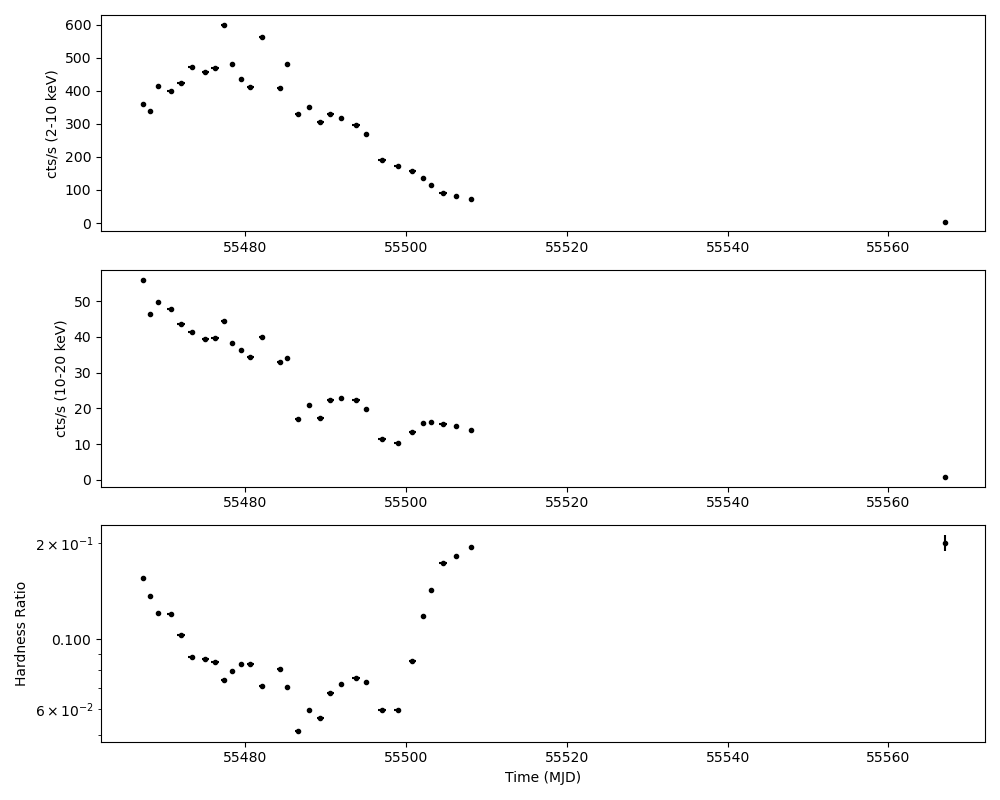

In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib widget

def plot_hd(t_mjd,t_mjd_err,cts_per_s_soft,cts_per_s_soft_err,cts_per_s_hard,cts_per_s_hard_err,ratio,ratio_err):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,8))
    ax1.errorbar(t_mjd,cts_per_s_soft, xerr=t_mjd_err, yerr=cts_per_s_soft_err, fmt='k.')
    ax1.set_ylabel("cts/s (2-10 keV)")
    ax2.errorbar(t_mjd,cts_per_s_hard, xerr=t_mjd_err, yerr=cts_per_s_hard_err, fmt='k.')
    ax2.set_ylabel("cts/s (10-20 keV)")
    ax3.errorbar(t_mjd,ratio, xerr=t_mjd_err, yerr=ratio_err, fmt='k.')
    ax3.set_ylabel("Hardness Ratio")
    ax3.set_xlabel("Time (MJD)")

    # ax3.set_ylim(0.001,10)
    ax3.set_yscale('log')

    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.ticklabel_format(style='plain',useOffset=False,axis='y')
    plt.tight_layout()
    plt.show()

t_mjd = []
t_mjd_err = []
cts_per_s_soft = []
cts_per_s_soft_err = []
cts_per_s_hard = []
cts_per_s_hard_err = []
ratio = []
ratio_err = []

ss = f_soft.readline()
hh = f_hard.readline()
while ss != '' and hh !='':
        row_soft = ss.split('  ')
        row_hard = hh.split('  ')
        if "#" not in row_soft[0] and "#" not in row_hard[0]:
            t_mjd.append(float(row_soft[0]))
            t_mjd_err.append(float(row_soft[1]))
            cts_per_s_soft.append(float(row_soft[2]))
            cts_per_s_soft_err.append(float(row_soft[3]))
            cts_per_s_hard.append(float(row_hard[2]))
            cts_per_s_hard_err.append(float(row_hard[3]))
            row_soft[2] = float(row_soft[2])
            row_soft[3] = float(row_soft[3])
            row_hard[2] = float(row_hard[2])
            row_hard[3] = float(row_hard[3])
            ratio.append(row_hard[2]/row_soft[2])
            ratio_err.append((row_hard[2]/row_soft[2])*math.sqrt(((row_hard[3]/row_hard[2])**2)+((row_soft[3]/row_soft[2])**2)))

        ss = f_soft.readline()
        hh = f_hard.readline()

t_mjd = np.array(t_mjd)
t_mjd_err = np.array(t_mjd_err)
cts_per_s_soft = np.array(cts_per_s_soft)
cts_per_s_soft_err = np.array(cts_per_s_soft_err)
cts_per_s_hard = np.array(cts_per_s_hard)
cts_per_s_hard_err = np.array(cts_per_s_hard_err)
ratio = np.array(ratio)
ratio_err = np.array(ratio_err)

if len(dates) > 0:
    print('Showing only observations between MJDs: ',dates[0],' and ',dates[1])
    t_mjd_index , = np.where((t_mjd >= int(dates[0])) & (t_mjd <= int(dates[1])))
    t_mjd = np.take(t_mjd,t_mjd_index)
    t_mjd_err = np.take(t_mjd_err,t_mjd_index)
    cts_per_s_soft = np.take(cts_per_s_soft,t_mjd_index)
    cts_per_s_soft_err = np.take(cts_per_s_soft_err,t_mjd_index)
    cts_per_s_hard = np.take(cts_per_s_hard,t_mjd_index)
    cts_per_s_hard_err = np.take(cts_per_s_hard_err,t_mjd_index)
    ratio = np.take(ratio,t_mjd_index)
    ratio_err = np.take(ratio_err,t_mjd_index)

# Create a mask for rows where the ratio is not negative
mask = ratio >= 0

t_mjd = t_mjd[mask]
t_mjd_err = t_mjd_err[mask]
ratio = ratio[mask]
ratio_err = ratio_err[mask]
cts_per_s_soft = cts_per_s_soft[mask]
cts_per_s_soft_err = cts_per_s_soft_err[mask]
cts_per_s_hard = cts_per_s_hard[mask]
cts_per_s_hard_err = cts_per_s_hard_err[mask]

mask = ratio_err >= 0

t_mjd = t_mjd[mask]
t_mjd_err = t_mjd_err[mask]
ratio = ratio[mask]
ratio_err = ratio_err[mask]
cts_per_s_soft = cts_per_s_soft[mask]
cts_per_s_soft_err = cts_per_s_soft_err[mask]
cts_per_s_hard = cts_per_s_hard[mask]
cts_per_s_hard_err = cts_per_s_hard_err[mask]

plot_hd(t_mjd,t_mjd_err,cts_per_s_soft,cts_per_s_soft_err,cts_per_s_hard,cts_per_s_hard_err,ratio,ratio_err)

total_count_rate = cts_per_s_soft + cts_per_s_hard

## Standardize data and perform PCA EVR analysis

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Combine into a single dataset
data = np.vstack((np.log(ratio), total_count_rate)).T

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

pca = PCA()
pca.fit_transform(data)
print(pca.explained_variance_ratio_)

[0.73270799 0.26729201]


## Perform k-mean clustering and plot classified data

c:\Users\ysabd\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ysabd\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


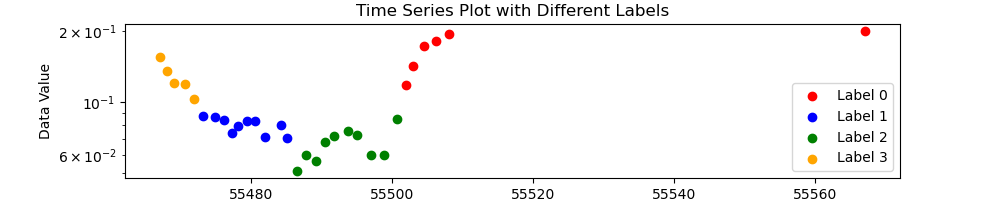

In [9]:
# Use a clustering algorithm to cluster the encoded data
from sklearn.cluster import KMeans,DBSCAN
kmeans = KMeans(n_clusters=4)  # Choose the appropriate number of clusters
# dbscan = DBSCAN(eps=0.3,min_samples=4)
clusters = kmeans.fit_predict(data)

# print(kmeans.cluster_centers_)

# Assign colors to each label
label_colors = ['red', 'blue', 'green', 'orange','purple','cyan','yellow']

# Create the plot
fig, ax = plt.subplots(figsize=(10,2))

# Iterate over the unique labels
for label in np.unique(clusters):
    mask = clusters == label
    ax.scatter(t_mjd[mask], ratio[mask], color=label_colors[label], label=f'Label {label}')

ax.set_xlabel('Time')
ax.set_ylabel('Data Value')
ax.set_title('Time Series Plot with Different Labels')
ax.set_yscale('log')
ax.legend()

plt.show()

### HID 

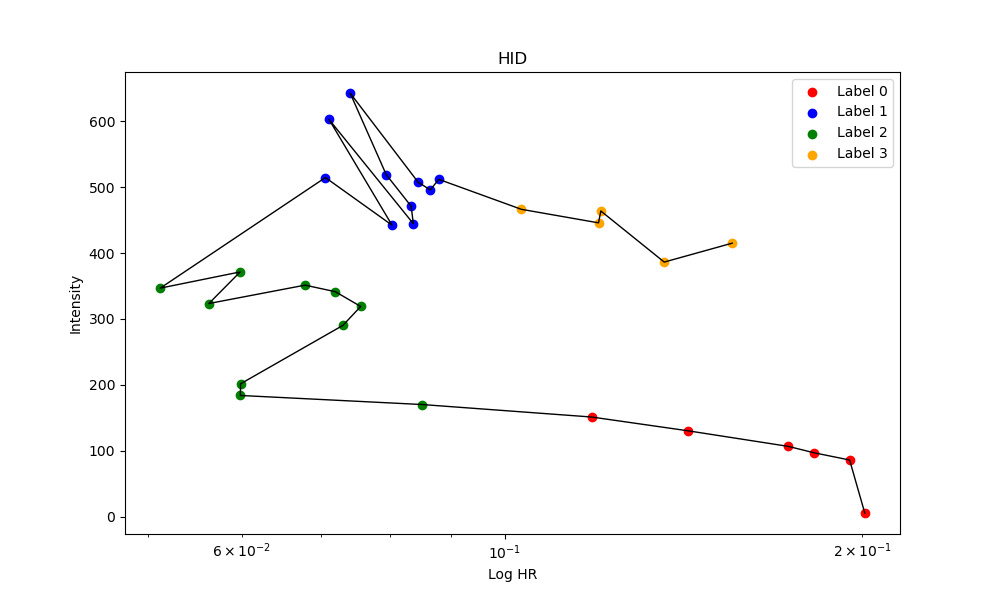

In [10]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over the unique labels
for label in np.unique(clusters):
    mask = clusters == label
    ax.scatter(ratio[mask],total_count_rate[mask], color=label_colors[label], label=f'Label {label}')
plt.plot(ratio, total_count_rate,'k',linewidth=1)


ax.set_xlabel('Log HR')
ax.set_ylabel('Intensity')
ax.set_title('HID')
ax.set_xscale('log')
ax.legend()

plt.show()